# Zillow Project Walk Through

# Goal

### We want to be able to predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017

# Set up Environment

In [1]:
# Bring in standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Import sql database credentials and python files that contain functions we will use
import tax_rate_distributions
import split_scale
import function
import env
from env import user, password, host


# Acquisition

Our data comes from the Zillow database on the SQL server. We filter out unnecessary data first and then read in the relevant data.

Due to a short turn around time, we will only be focusing on a handful of fields: bedroom count, bathroom count, and finished sqaure footage. Given more time, we can incorporate more fields and possibly create an even more accurate model.

In [2]:
# Create variable to access zillow database
url = f'mysql+pymysql://{user}:{password}@{host}/zillow'
# Read in sql database to python. Sort out properties that do not meet criteria
data = pd.read_sql('''select id, calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, taxvaluedollarcnt from properties_2017
join predictions_2017 using (id)
join propertylandusetype using (propertylandusetypeid)
where transactiondate between "2017-05-01" and "2017-06-30"
and propertylandusetypeid not in ("31", "47", "246", "247", "248","264", "265", "266","267", "269", "270" )
and calculatedfinishedsquarefeet * bathroomcnt * bedroomcnt != 0
and taxvaluedollarcnt != 0''',url)
# Set index to data id to be able to identify each individual property
data = data.set_index(data.id)

Here we take a peak at the data. We have 16,023 properties with a mean tax value of $ 464,270.

In [3]:
data.head()

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
id,,,,,
1772,1772,1604.0,4.0,2.0,498347.0
2028,2028,2384.0,3.0,3.0,549917.0
3273,3273,1574.0,3.0,2.0,235272.0
3429,3429,1619.0,2.0,2.0,340000.0
4505,4505,2408.0,2.0,3.0,2017254.0


A quick pair plot to see the relationship between all fields

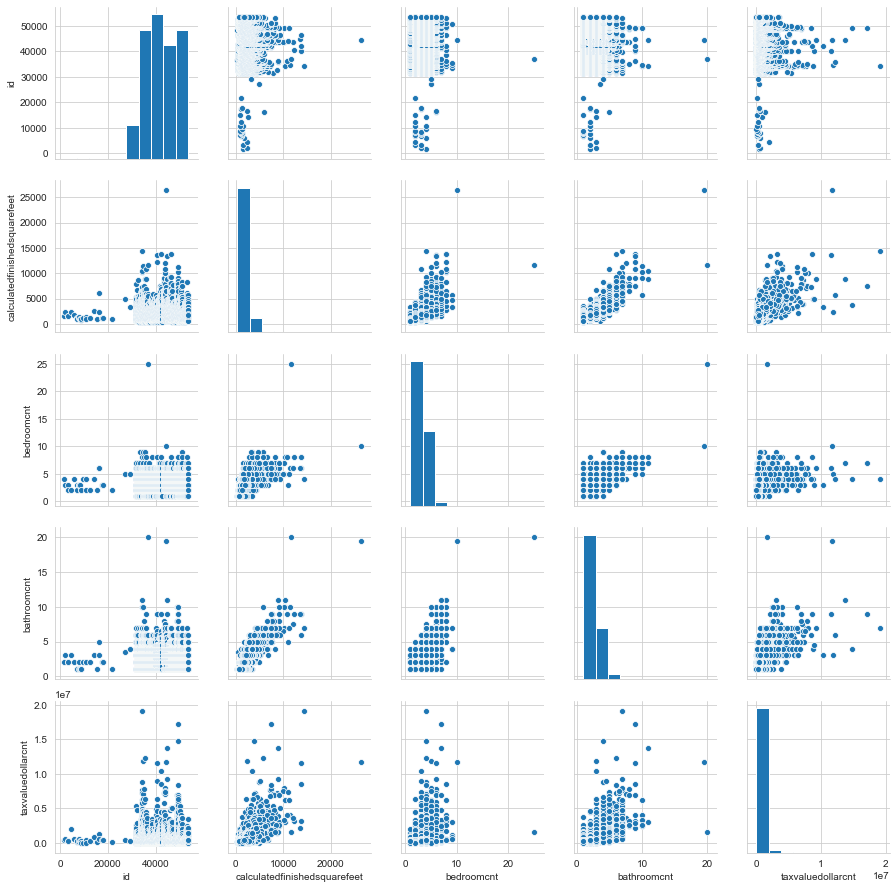

In [4]:
sns.pairplot(data=data)

## Additional Info

Before we get started exploring our data to create a model, we would like to know a couple of things:

- We would like to know what states and counties these properties are located in.

Our data contains a column called fips which contains the Federal Information Processing Standard Publication county codes.

In [5]:
# Distinct fips county codes
county_codes = pd.read_sql('''select distinct fips from properties_2017
join predictions_2017 using (id)
join propertylandusetype using (propertylandusetypeid)
where transactiondate between "2017-05-01" and "2017-06-30"
and propertylandusetypeid not in ("31", "47", "246", "247", "248","264", "265", "266","267", "269", "270" )
and taxdelinquencyflag is null''',url)
county_codes.head()

,fips
0,6111.0
1,6037.0
2,6059.0


Fips codes are 5 digits while ours are only 4 digit. The leading zero is missing from our data. Once we add the leading zero, we can look up the values on this website: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

06111 is Ventura County, California

06037 is Los Angeles County, California

06059 is Orange County, California

- Also, we'd like to know the distribution of tax rates for each county.

In [6]:
los_angeles_county_data = pd.read_sql('''select taxamount, taxvaluedollarcnt from properties_2017
join predictions_2017 using (id)
join propertylandusetype using (propertylandusetypeid)
where transactiondate between "2017-05-01" and "2017-06-30"
and propertylandusetypeid not in ("31", "47", "246", "247", "248","264", "265", "266","267", "269", "270" )
and taxdelinquencyflag is null
and fips like "6037"''',url)

(       taxamount  taxvaluedollarcnt  tax_rate_percent
 0        6089.82           498347.0          1.222004
 1        6679.55           549917.0          1.214647
 2        3876.31           235272.0          1.647587
 3        4206.15           340000.0          1.237103
 4       24353.42          2017254.0          1.207256
 5       75862.41          5240710.0          1.447560
 6        6861.51           629951.0          1.089213
 7        5488.23           305481.0          1.796586
 8        1498.86            79930.0          1.875216
 9        3473.87           260000.0          1.336104
 10       1048.54            66220.0          1.583419
 11       7072.55           595000.0          1.188664
 12       3839.92           275061.0          1.396025
 13       3433.84           285180.0          1.204096
 14        916.49            49719.0          1.843340
 15        597.84            33196.0          1.800940
 16      16345.17          1335281.0          1.224100
 17       

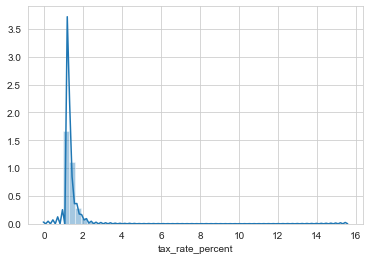

In [7]:
# Created a function that accepts county data as input and returns two things: The database with null values and a plot of the tax rate distribution
tax_rate_distributions.drop_nulls_add_tax_rate_percent(los_angeles_county_data)

In [8]:
orange_county_data = pd.read_sql('''select taxamount, taxvaluedollarcnt from properties_2017
join predictions_2017 using (id)
join propertylandusetype using (propertylandusetypeid)
where transactiondate between "2017-05-01" and "2017-06-30"
and propertylandusetypeid not in ("31", "47", "246", "247", "248","264", "265", "266","267", "269", "270" )
and taxdelinquencyflag is null
and fips like "6059"''',url)

(      taxamount  taxvaluedollarcnt  tax_rate_percent
 0       5822.90           479778.0          1.213665
 1        872.48            50102.0          1.741408
 2       2953.10           290614.0          1.016159
 3       9740.22           829744.0          1.173883
 4       5235.58           465753.0          1.124111
 5       4090.82           342564.0          1.194177
 6       3117.46           255401.0          1.220614
 7       5322.70           445876.0          1.193762
 8       3566.08           288575.0          1.235755
 9       3107.62           254520.0          1.220973
 10      1202.60            83930.0          1.432861
 11      7758.84           671028.0          1.156262
 12      4583.52           379685.0          1.207190
 13      2847.00           231182.0          1.231497
 14      6161.62           521000.0          1.182653
 15      1853.40           135207.0          1.370787
 16      6578.38           232137.0          2.833835
 17      5067.24           4

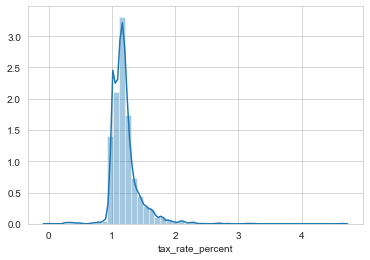

In [9]:
tax_rate_distributions.drop_nulls_add_tax_rate_percent(orange_county_data)

In [10]:
ventura_county_data = pd.read_sql('''select taxamount, taxvaluedollarcnt from properties_2017
join predictions_2017 using (id)
join propertylandusetype using (propertylandusetypeid)
where transactiondate between "2017-05-01" and "2017-06-30"
and propertylandusetypeid not in ("31", "47", "246", "247", "248","264", "265", "266","267", "269", "270" )
and taxdelinquencyflag is null
and fips like "6111"''',url)

(     taxamount  taxvaluedollarcnt  tax_rate_percent
 0       212.46            27400.0          0.775401
 1      1489.06           126974.0          1.172728
 2      4224.78           358876.0          1.177226
 3      8030.60           733940.0          1.094177
 4      8650.36           769907.0          1.123559
 5       497.84           224593.0          0.221663
 6      4715.00           403030.0          1.169888
 7      4285.10           364965.0          1.174113
 8     19117.34          1808125.0          1.057302
 9     13380.72          1243000.0          1.076486
 10     4478.84           383056.0          1.169239
 11     8250.30           776889.0          1.061966
 12     4872.10           360391.0          1.351893
 13     8708.02           714000.0          1.219611
 14     4478.58           421966.0          1.061360
 15     5341.74           496189.0          1.076553
 16     5637.74           529683.0          1.064361
 17     5965.52           476000.0          1.

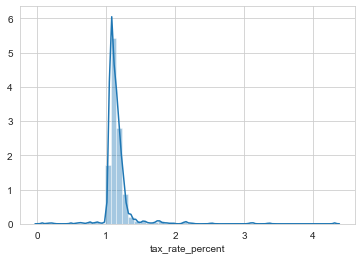

In [11]:
tax_rate_distributions.drop_nulls_add_tax_rate_percent(ventura_county_data)

(     taxamount  taxvaluedollarcnt  tax_rate_percent
 0       212.46            27400.0          0.775401
 1      1489.06           126974.0          1.172728
 2      4224.78           358876.0          1.177226
 3      8030.60           733940.0          1.094177
 4      8650.36           769907.0          1.123559
 5       497.84           224593.0          0.221663
 6      4715.00           403030.0          1.169888
 7      4285.10           364965.0          1.174113
 8     19117.34          1808125.0          1.057302
 9     13380.72          1243000.0          1.076486
 10     4478.84           383056.0          1.169239
 11     8250.30           776889.0          1.061966
 12     4872.10           360391.0          1.351893
 13     8708.02           714000.0          1.219611
 14     4478.58           421966.0          1.061360
 15     5341.74           496189.0          1.076553
 16     5637.74           529683.0          1.064361
 17     5965.52           476000.0          1.

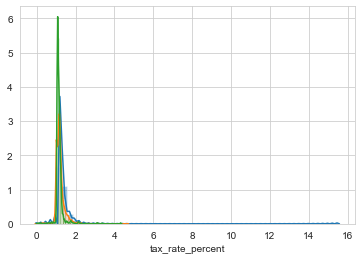

In [12]:
tax_rate_distributions.drop_nulls_add_tax_rate_percent(los_angeles_county_data)

tax_rate_distributions.drop_nulls_add_tax_rate_percent(orange_county_data)

tax_rate_distributions.drop_nulls_add_tax_rate_percent(ventura_county_data)

## Split Data

In [13]:
# Split data into 80% train and 20% test
train, test = split_scale.split_my_data(data)
# Define X_train variable as target features: bedroom count, bathroom count, and finished square footage
X_train = train.drop(columns=["id", "taxvaluedollarcnt"])
y_train = pd.DataFrame([train.taxvaluedollarcnt])
# y_train is our target variable tax value dollar amount
y_train = y_train.transpose()
# This test data won't be used until after we have created a model. It is used to test the effectiveness of the model.
X_test = test.drop(columns=["id", "taxvaluedollarcnt"])
y_test = pd.DataFrame([test.taxvaluedollarcnt])
y_test = y_test.transpose()

In [14]:
X_train.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt
id,,,
38745,1325.0,3.0,2.0
50623,2653.0,4.0,3.0
49742,1404.0,3.0,1.0
32634,1043.0,2.0,1.0
52220,392.0,1.0,1.0


In [15]:
y_train.head()

,taxvaluedollarcnt
id,
38745,438000.0
50623,1114725.0
49742,156815.0
32634,54630.0
52220,86974.0


## Scale Data

In [16]:
X_train_scaled = split_scale.standard_scaler(X_train)

In [17]:
X_train_scaled.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt
38745,-0.514584,-0.267427,-0.207336
50623,0.821766,0.775431,0.763844
49742,-0.435087,-0.267427,-1.178516
32634,-0.798357,-1.310285,-1.178516
52220,-1.453451,-2.353143,-1.178516


# Explore

Here we can start exploring our features to see how they relate to each other and how they relate to our target variable. 

- Here is a heatmap showing the correlations between our variables:

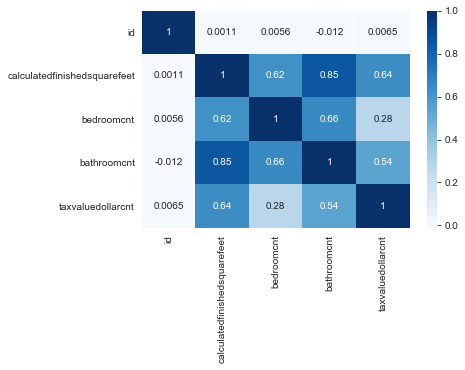

In [18]:
sns.heatmap(data.corr(), cmap='Blues', annot=True)

Here we use the select k-best function to rank the features. Finished square footage has the highest score. 

In [19]:
function.select_kbest_freg(X_train_scaled, y_train, k=3)

['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

Now we will start creating different models to see which combination of features performs best. 

In [20]:
# Create a dataframe to store the baseline and models
predictions=pd.DataFrame({'actual':y_train.taxvaluedollarcnt}).reset_index(drop=True)

In [21]:
# baseline model is the mean tax value
predictions['baseline'] = y_train.mean()[0]
predictions.head()

,actual,baseline
0,438000.0,464282.479092
1,1114725.0,464282.479092
2,156815.0,464282.479092
3,54630.0,464282.479092
4,86974.0,464282.479092


In [22]:
# model 1 using square feet only
lm1=LinearRegression()
lm1.fit(X_train_scaled[['calculatedfinishedsquarefeet']],y_train)
lm1_predictions=lm1.predict(X_train_scaled[['calculatedfinishedsquarefeet']])
predictions['lm1']=lm1_predictions

In [23]:
# model 2 using square feet and bedroom count
lm2=LinearRegression()
lm2.fit(X_train_scaled[['calculatedfinishedsquarefeet', 'bedroomcnt']],y_train)
lm2_predictions=lm2.predict(X_train_scaled[['calculatedfinishedsquarefeet', 'bedroomcnt']])
predictions['lm2']=lm2_predictions

In [24]:
# model 3 using all three variables
lm3=LinearRegression()
lm3.fit(X_train_scaled[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']],y_train)
lm3_predictions=lm3.predict(X_train_scaled[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']])
predictions['lm3']=lm3_predictions

In [25]:
# model 4 using square feet and bathroom count
lm4=LinearRegression()
lm4.fit(X_train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt']],y_train)
lm4_predictions=lm4.predict(X_train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt']])
predictions['lm4']=lm4_predictions

In [26]:
# model 5 using bedroom count and bathroom count
lm5=LinearRegression()
lm5.fit(X_train_scaled[['bedroomcnt', 'bathroomcnt']],y_train)
lm5_predictions=lm5.predict(X_train_scaled[['bedroomcnt', 'bathroomcnt']])
predictions['lm5']=lm5_predictions

In [27]:
# model 6 using bedroom only
lm6=LinearRegression()
lm6.fit(X_train_scaled[['bedroomcnt']],y_train)
lm6_predictions=lm6.predict(X_train_scaled[['bedroomcnt']])
predictions['lm6']=lm6_predictions

In [28]:
# model 7 using bathroom only
lm7=LinearRegression()
lm7.fit(X_train_scaled[['bathroomcnt']],y_train)
lm7_predictions=lm7.predict(X_train_scaled[['bathroomcnt']])
predictions['lm7']=lm7_predictions

In [29]:
predictions.head()

,actual,baseline,lm1,lm2,lm3,lm4,lm5,lm6,lm7
0,438000.0,464282.479092,244151.497282,237318.921663,247979.567224,239887.987805,401939.064235,414562.955570,390223.348490
1,1114725.0,464282.479092,815820.929717,781328.532488,781779.592275,814560.926244,712844.024927,608449.433362,737122.649078
2,156815.0,464282.479092,278158.940928,277766.532302,237964.275409,293259.454230,-2832.441956,414562.955570,43324.047902
3,54630.0,464282.479092,122757.837684,228856.155501,213020.905515,132119.418583,91034.103543,220676.477777,43324.047902
4,86974.0,464282.479092,-157480.716921,31467.208000,49775.436799,-158468.291130,184900.649042,26789.999985,43324.047902


# Evaluate and Model

Now let's evaluate these models to see which performs the best. We evaluate the models by comparing their Mean Square Errors, Sum of Square Errors, Root Mean Square Error, and R-squared score.

In [30]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print(MSE_1,SSE_1,RMSE_1,r2_1)

256762749454.66782 3291184922509932.0 506717.6229959521 0.41613255549012607


In [31]:
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print(MSE_2,SSE_2,RMSE_2,r2_2)

246338700230.99075 3157569459560839.5 496325.19604689704 0.4398363949084214


In [32]:
MSE_3 = mean_squared_error(predictions.actual, predictions.lm3)
SSE_3 = MSE_3*len(predictions.actual)
RMSE_3 = sqrt(MSE_3)
r2_3 = r2_score(predictions.actual, predictions.lm3)
print(MSE_3,SSE_3,RMSE_3,r2_3)

245730450631.4941 3149772916194491.5 495712.0642383985 0.4412195283264757


In [33]:
MSE_4 = mean_squared_error(predictions.actual, predictions.lm4)
SSE_4 = MSE_4*len(predictions.actual)
RMSE_4 = sqrt(MSE_4)
r2_4 = r2_score(predictions.actual, predictions.lm4)
print(MSE_4,SSE_4,RMSE_4,r2_4)

256664671357.7786 3289927757464006.0 506620.83588989766 0.4163555808624385


In [34]:
MSE_5 = mean_squared_error(predictions.actual, predictions.lm5)
SSE_5 = MSE_5*len(predictions.actual)
RMSE_5 = sqrt(MSE_5)
r2_5 = r2_score(predictions.actual, predictions.lm5)
print(MSE_5,SSE_5,RMSE_5,r2_5)

307624125148.90826 3943126036158706.0 554638.733906052 0.3004759755776424


In [35]:
MSE_6 = mean_squared_error(predictions.actual, predictions.lm6)
SSE_6 = MSE_6*len(predictions.actual)
RMSE_6 = sqrt(MSE_6)
r2_6 = r2_score(predictions.actual, predictions.lm6)
print(MSE_6,SSE_6,RMSE_6,r2_6)

405196412940.0437 5193807621065480.0 636550.4009424892 0.07860079139073095


In [36]:
MSE_7 = mean_squared_error(predictions.actual, predictions.lm7)
SSE_7 = MSE_7*len(predictions.actual)
RMSE_7 = sqrt(MSE_7)
r2_7 = r2_score(predictions.actual, predictions.lm7)
print(MSE_7,SSE_7,RMSE_7,r2_7)

312174818059.2801 4001456817883852.0 558726.0671020102 0.29012789570246134


#### Model 3 performs the best overall. This model includes all three features: finished square footage, bedroom count, and bathroom count. Below is the equation for our model along with the y-intercept and coefficients.

In [37]:
lm3_y_intercept=lm3.intercept_
print("intercept: ",lm3_y_intercept)
lm3_coefficients=lm3.coef_
print("coefficents: ",lm3_coefficients)
print('{}= b+ m1*{} + m2*{} + m3*{}'.format(y_train.columns[0],X_train.columns[0],X_train.columns[1],X_train.columns[2]))


intercept:  [464282.4790919]
coefficents:  [[ 473923.89101277 -141168.68822361   49105.91579902]]
taxvaluedollarcnt= b+ m1*calculatedfinishedsquarefeet + m2*bedroomcnt + m3*bathroomcnt


### Apply to test data

In [38]:
mvp_model=lm3.predict(X_test[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']])
mvp_model=mvp_model.ravel().reshape(3205)
y_test1=np.array(y_test).ravel().reshape(3205)
best_model=pd.DataFrame({'predictions':mvp_model,'taxvaluedollarcnt':y_test1})
best_model.head()

,predictions,taxvaluedollarcnt
0,1.683714e+09,886360.0
1,4.839662e+08,101445.0
2,7.791287e+08,471021.0
3,5.147712e+08,44435.0
4,6.767611e+08,332569.0


#### Now we plot the residuals to make sure they are as close to zero as possible.

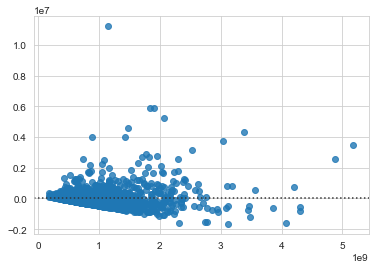

In [39]:
sns.residplot(mvp_model, y_test)

#### Lastly, we plot the predicted tax values of our most accurate model against the actual values. We also plot our baseline predicted values for comparison.

Text(0.5, 1, 'Predicted vs Actual Tax Value')

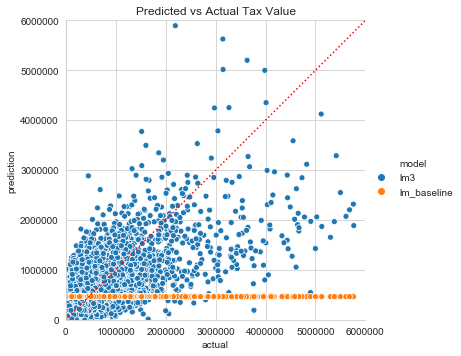

In [40]:
pd.DataFrame({'actual': predictions.actual,
              'lm3': predictions.lm3,
              'lm_baseline': predictions.baseline.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
min = 0
max = 6_000_000
plt.plot([min, max],[min, max], c='red', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

# Conclusion

#### We evaluated all possible combinations of finished square footage, bedroom count, and bathroom count. We determine that the most accurate model incorporates all three features. This model performs better than our baseline model. 

#### Given more time to explore the data set, we could use fields to create new features and possibly create an even better model. 